# Recommendation System

>A Recommendation System is an engine that operates like a filter predicting the preferences of a group of items for a user amongst a universal set of items, and recommends the closest ‘x’ items based on various parameters.
![Recommendation System Image](https://miro.medium.com/max/640/1*D8qyeXxlbHFUlpZtfjvM7Q.png)

In [21]:
import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
from textblob.sentiments import NaiveBayesAnalyzer
import nltk

In [22]:
import os
os.chdir(os.getcwd())

In [23]:
import pytreebank
import sys

dataset = pytreebank.load_sst()

In [24]:
out_path = os.path.join(sys.path[0], 'sst_{}.txt')
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))

In [25]:
train = pd.read_csv('sst_train.txt', sep='\t',header=None, names=['sentiment_label', 'sentence'])

## Train Model

In [26]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
train['vader_score'] = train["sentence"].apply(lambda Description: sid.polarity_scores(Description))

In [28]:
train['compound'] = train['vader_score'].apply(lambda score_dict: score_dict['compound'])
train['vader_pred'] = pd.cut(train['compound'], bins=5, labels=[1, 2, 3, 4, 5])

## Amazon Book Reviews Dataset

In [29]:
data = pd.read_csv('Amazon Book Reviews.csv', usecols=[0,1,2,4,5,9])
data.head()

,reviewerID,asin,reviewerName,reviewText,overall,title
0,A15Q7ABIU9O9YZ,60554800,Larry Scantlebury,This is my first GM Ford book and I will read ...,3,"Red Tide: A Novel (Ford, G. M.)"
1,AUIJDXNYVTEA8,60554800,Les Stockton,I liked the story. I thought the book added a...,4,"Red Tide: A Novel (Ford, G. M.)"
2,A20N5GOON55TE9,60554800,lila,"As always, G.M. Ford does not disappoint. I st...",5,"Red Tide: A Novel (Ford, G. M.)"
3,A1CT8ENDZSYTX3,60554800,Lisa B.,I love Ford's Leo Waterman series and the firs...,3,"Red Tide: A Novel (Ford, G. M.)"
4,A2SI6BNK5SWSMD,60554800,L. J. Roberts,It was nice to see Corso working with the poli...,3,"Red Tide: A Novel (Ford, G. M.)"


### Data Analysis

In [30]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [45]:
reviews = list(data['reviewText'])

In [46]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [47]:
nltk.download('rslp')
tokenizer = RegexpTokenizer(r'\w+')
nltk.download('stopwords')
en_stopwords = set(stopwords.words('english'))
ps = nltk.stem.RSLPStemmer()

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
def getCleanComment(review):
    review = str(review)
    review = review.lower()
    review = review.replace('"','')
    review = review.replace(';','')
    review = review.replace('_','')
    review = review.replace('-','')
    review = review.replace(',','')
    review = re.sub('\d', '', review)
    tokens = tokenizer.tokenize(review)
    new_tokens = [i for i in tokens if i not in en_stopwords]
    stemmed_tokens = [ps.stem(i) for i in new_tokens]
    
    cleaned_review = ' '.join(stemmed_tokens)
    return cleaned_review

In [49]:
preprocessed_reviews = [getCleanComment(i) for i in reviews]

In [50]:
data['preprocessed_reviews'] = preprocessed_reviews
data['vader_score'] = data["preprocessed_reviews"].apply(lambda Description: sid.polarity_scores(Description))

In [51]:
data['compound'] = data['vader_score'].apply(lambda score_dict: score_dict['compound'])
data['vader_pred'] = pd.cut(data['compound'], bins=5, labels=[1, 2, 3, 4, 5])

In [53]:
deselectlist =['reviewerID', 'asin' , 'title', 'reviewerName', 'reviewText', 'overall', 'vader_pred']
data.loc[:,deselectlist].to_csv('newAmazonBooksRatings.csv', index=False)

## Filtering Irrelevant Users using Link Analysis
> ### What is Link Analysis
Link analysis is the process of investigating social structures by the use of networks and graphs.
To help with the use case we are trying to solve, link analysis helps in the following ways:
> - Identifying anomaly nodes of a network (irrelevant users) who can be turned off to refine produced set of recommendations
> - Predicting new links on already built social network to interrelate a new product with older ones having similar features


In [54]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [55]:
data = pd.read_csv('Amazon Book Reviews.csv')
data.head()
print(type(data))
df = pd.DataFrame(data, columns = ['reviewerID', 'asin', 'title', 'reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime'])

<class 'pandas.core.frame.DataFrame'>


#### Unweighted graph (visualization)

In [56]:
#unweighted graph (visualization)

G = nx.Graph() 
for i in range(len(df)):
    for j in range(len(df)):
        if i!=j and df['title'][i] == df['title'][j]:
            G.add_edge(i,j)

#### Weighted graph

In [ ]:
#weighted graph


# creating a multigraph able to contain multiple edges between nodes, 
# weight between edges being the mean of user ratings given by both

GW = nx.MultiGraph() 
for i in range(len(df)):
    for j in range(len(df)):
        if i!=j and df['title'][i] == df['title'][j]:
            GW.add_edge(df['reviewerID'][i],df['reviewerID'][j], weight = (int)(df['overall'][i]+df['overall'][j])/2)

#### Visualizing network with degree

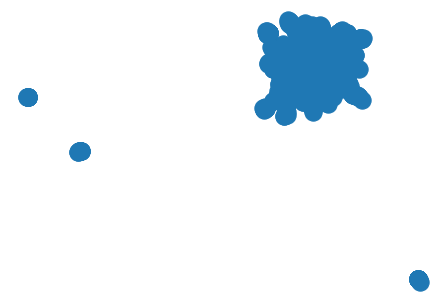

In [31]:
nx.draw(GW)
plt.savefig("gw_path.jpg",dpi=399)

In [ ]:
print(nx.info(GW)) # same node for repeated user
print(nx.info(G)) # different node for repeated user

In [ ]:
max_node_list = sorted(GW.degree, key=lambda x: x[1], reverse=True)
max_node_list[:10]

In [ ]:
print(max_node_list[-1])
max_node_list_unweighted = sorted(G.degree, key = lambda x: x[1], reverse=True)
print(max_node_list_unweighted[-1])

#### Visualizing network by betweenness centrality

In [ ]:
pos = nx.spring_layout(G)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [200.0 * G.degree(v) for v in G]
node_size =  [v * 100 for v in betCent.values()]
plt.figure(figsize=(8,8))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

In [ ]:
nx.average_clustering(G)

In [ ]:
forward_dict = nx.triangles(G)
dict(sorted(forward_dict.items(), key=lambda item: item[1]))

In [ ]:
gm = nx.google_matrix(GW, alpha = 0.89)
#print(gm)

#### Finding min page rank nodes from graph

In [ ]:
pr = nx.pagerank_numpy(G) # will return dict of user node page ranks
#print(pr)
# finding min page rank nodes from graph
minval = min(pr.values())
res = [k for k, v in pr.items() if v==minval]
#print(res)

#### Irrelevant users (based on page rank scores)

In [ ]:
# irrelevant users (based on page rank scores) ->
irrelevant_users = df.iloc[3:11,['reviewerID','reviewerName']]
print(irrelevant_users)

In [ ]:
prw = nx.pagerank_numpy(GW)
minvalw = min(prw.values())
resw = [k for k, v in prw.items() if v==minvalw]
print(resw) # min page rank nodes in weighted, multi graph

In [ ]:
GW.degree('A1RREZ3HGOVT4D') # degree of min page rank node in weighted, multi graph

In [ ]:
G.degree(3) # degree of min page rank node in unweighted graph

In [ ]:
# printing page ranks of important nodes for weighted graph ->

print(prw.get('AFVQZQ8PW0L')) # node with max edges
print(prw.get('A1RREZ3HGOVT4D')) # node with min page rank
print(prw.get('A1W0Z6DWSQAFHN')) # node with min edges

# nodes with min degree in graph are necessarily not anomalous nodes according to the page rank algorithm
# an inference can be that newer users on a platform providing ratings may have less degree in the product
# social network, but will not be directly treated as anomalies based on their usage pattern

In [ ]:
# Removing irrelevant users from the newAmazonBooksRatings dataset WIP

In [ ]:
import math
import copy
from sklearn.metrics import *
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

## Collaborative Filtering using SVD
> ### What is Collaborative Filtering
Collaborative filtering technique is based on the idea that users that preferred certain items in the past are likely to agree again in the future. It filters out products that a user might prefer on the basis of activity by similar users.
> ### What is SVD
SVD is Singular Vector Decomposition. What it does is that it decomposes a matrix into constituent arrays of feature vectors corresponding to each row and each column.

In [ ]:
from pandas import DataFrame
ratings_data = pd.read_csv("newAmazonBooksRatings.csv", usecols = [0,1,2,5,6], header=0, names = ["user_id", "book_id", "book_name", "user_rating", "sentiment_rating"])
ratings_data = ratings_data.assign(newUserId = ratings_data['user_id'].astype('category').cat.codes)
ratings_data = ratings_data.assign(newBookId = ratings_data['book_id'].astype('category').cat.codes)
newRatingCol = ratings_data.loc[:, "user_rating":"sentiment_rating"]
ratings_data["mean_rating"] = newRatingCol.mean(axis=1)
ratings_data.drop(["user_id","book_id", "user_rating", "sentiment_rating"], axis=1, inplace=True)
cols = ["newBookId","book_name"]
books = ratings_data[cols].copy()
books.drop_duplicates(inplace=True)
books = books.reset_index(drop=True)
reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(ratings_data[["newUserId", "newBookId", "mean_rating"]], reader)
trainset = train_data.build_full_trainset()

In [ ]:
from surprise import SVD
from surprise.model_selection import cross_validate
svd = SVD(n_factors=100, n_epochs=5, biased=True, random_state=15, verbose=True)
results = cross_validate(svd, train_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

In [ ]:
model=svd.fit(trainset)

In [ ]:
def estSort(pred):
    return pred.est
def recommend_books(user_id, num_recommendations) :
    predictions = []
    for x in pd.unique(ratings_data['newBookId']):
        predictions.append(svd.predict(uid=0, iid=x))
    predictions.sort(key = estSort, reverse=True)
    recommendations = [x.iid for x in predictions[:num_recommendations]]
    return recommendations

In [ ]:
book_indices=recommend_books(user_id=101, num_recommendations=7)
recommendations = [books.values[x] for x in book_indices]
recommendations = DataFrame(recommendations, columns=["book_id", "book_name"])

In [ ]:
movie_ratings = ratings_data.pivot(
    index='newUserId',
    columns='newBookId',
    values='mean_rating'
).fillna(0)


In [ ]:
R = movie_ratings.values
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R, k = 50)

In [ ]:
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
#print(all_user_predicted_ratings)

In [ ]:
def recommend_books(predictions, user_index, books, org_matrix, num_recommendations=5):
    sorted_books = (-predictions[user_index]).argsort()
    boolArr = (org_matrix[user_index] == 0)
    unknown_sorted_books = [x for x in sorted_books if boolArr[x]]
    recommendations = [books[x] for x in unknown_sorted_books][:num_recommendations]               
    return recommendations

In [ ]:
top_books = recommend_books(all_user_predicted_ratings, 1, books.values, R, 7)
top_books = DataFrame(top_books, columns=["book_id", "book_name"])
print(top_books)

## Recommendation System

In [ ]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(list_1, list_2):
    cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))
    return cos_sim

def top_cosine_similarity(data, book_id, top_n=10):
    index = book_id - 1 
    book_row = data[index, :]
    similarity_values = np.zeros(shape=[data.shape[0]-1,2])
    k=0
    for i in range(data.shape[0]):
        if i != index :
            val = cosine_similarity(book_row, data[i, :])
            similarity_values[k] = np.array([i, val])
            k = k + 1
            
    sort_indices = np.argsort(-similarity_values[:, 1])
    return sort_indices[:top_n]

In [ ]:
val = input("Enter your favorite book id: ")
val = int(val)

In [ ]:
top_book_indices = top_cosine_similarity(Vt.T, val)
similar_books = [books.values[x] for x in top_book_indices]
similar_books = DataFrame(similar_books, columns=["book_id", "book_name"])

In [ ]:
print("Books similar to "+books.book_name[val-1]+" are:\n")
print(similar_books)